# Sentiment Analysis of IMDB Movie Reviews

### Problem Statement:
The goal of this project is to build a sentiment analysis model on IMDb movie reviews. The objective is to classify whether a review is positive or negative using NLP techniques and machine learning models. This can help movie producers, marketers, and platforms like IMDb understand public opinion at scale.

## Importing Libraries

In [54]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
!pip install swifter
import swifter
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import wordcloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading and Exploring Dataset

In [2]:
df=pd.read_csv(r"C:\Users\Hp\Downloads\archive (8)\IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [49]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


review       0
sentiment    0
dtype: int64

In [48]:
# Shape and preview
print("Shape of dataset:", df.shape)

Shape of dataset: (50000, 2)


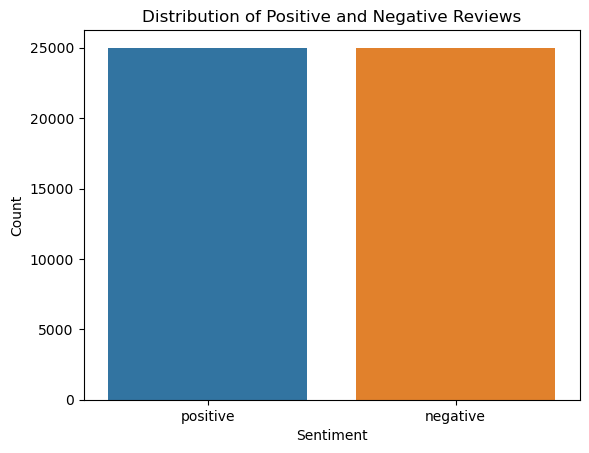

In [51]:
##  Class Distribution
sns.countplot(data=df, x='sentiment')  # Replace 'sentiment' with your label column
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [52]:
df['sentiment'].value_counts()  

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

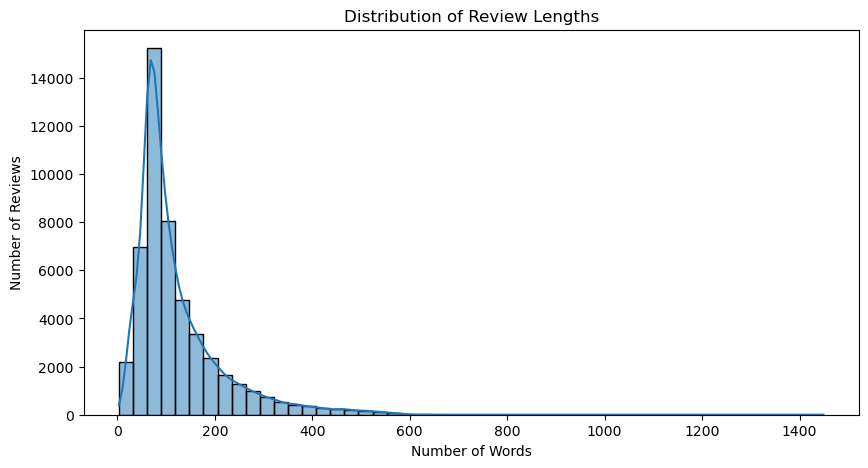

In [53]:
# Add a column for review length
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Histogram of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()


Right-skewed distribution: The majority of reviews are between 50 and 300 words, peaking around 100 words.

There are a few extremely long reviews (up to ~1500 words), but they are rare (outliers).

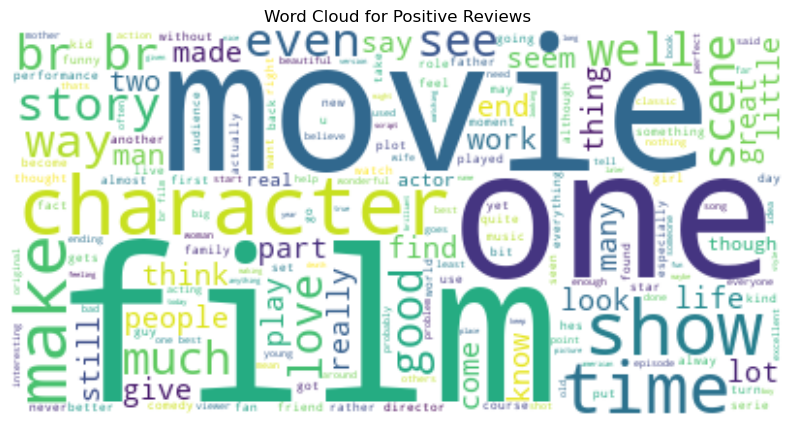

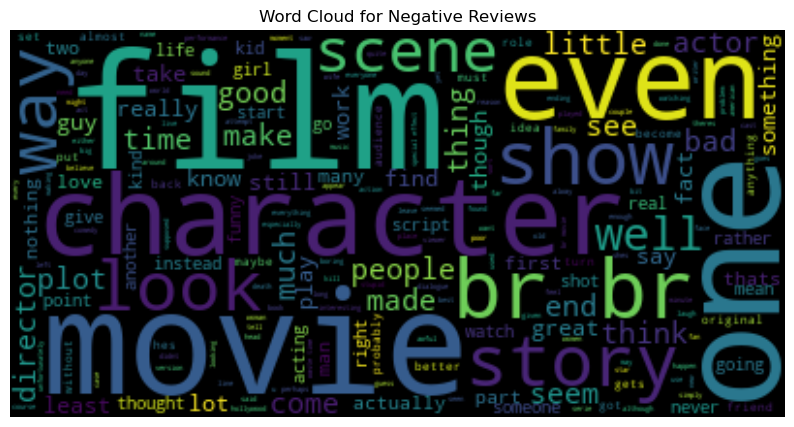

In [57]:
from wordcloud import WordCloud

# Separate positive and negative reviews
positive_text = " ".join(df[df['sentiment']=="positive"]['review'])
negative_text = " ".join(df[df['sentiment']=='negative']['review'])

# Wordcloud for positive
plt.figure(figsize=(10,6))
wordcloud_pos = WordCloud(background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

# Wordcloud for negative
plt.figure(figsize=(10,6))
wordcloud_neg = WordCloud(background_color='black').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()


In [58]:
# Positive review
print("Example Positive Review:")
print(df[df['sentiment']=='positive']['review'].iloc[0])

# Negative review
print("\nExample Negative Review:")
print(df[df['sentiment']=='negative']['review'].iloc[0])


Example Positive Review:
one reviewers mentioned watching 1 oz episode youll hooked right exactly happened mebr br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill ord

## Text Cleaning and Preprocessing

#### Text Preprocessing Summary

To prepare the text data for modeling, we performed the following preprocessing steps:

1. **Lowercasing**  
   - Converted all text to lowercase to maintain uniformity.  
   - Example: `"Great Movie!"` → `"great movie!"`

2. **Removing Punctuation**  
   - Removed all punctuation marks using regex.
   - Example: `"hello!"` → `"hello"`

3. **Removing Stopwords**  
   - Removed common English stopwords like "the", "is", "and" using NLTK.
   - This reduces noise in the data.

4. **Tokenization**  
   - Split each review into individual words (tokens).
   - Example: `"great movie"` → `["great", "movie"]`

5. **Lemmatization**   
   - Converted words to their base form using WordNetLemmatizer.
   - Example: `"running"` → `"run"`

6. **Vectorization (TF-IDF)**  
   - Transformed the cleaned reviews into numerical format using `TfidfVectorizer`.
   - This allowed us to feed the data into machine learning models.


In [5]:
## Lowercase
df['review']=df['review'].apply(lambda x: x.lower())

In [6]:
## removing punctuation
df['review']=df['review'].apply(lambda x: ''.join(i for i in x if i not in string.punctuation))

In [7]:
## Tokenization
df['review']=df['review'].apply(lambda x: x.split())

In [8]:
df['review']

0        [one, of, the, other, reviewers, has, mentione...
1        [a, wonderful, little, production, br, br, the...
2        [i, thought, this, was, a, wonderful, way, to,...
3        [basically, theres, a, family, where, a, littl...
4        [petter, matteis, love, in, the, time, of, mon...
                               ...                        
49995    [i, thought, this, movie, did, a, down, right,...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, am, a, catholic, taught, in, parochial, el...
49998    [im, going, to, have, to, disagree, with, the,...
49999    [no, one, expects, the, star, trek, movies, to...
Name: review, Length: 50000, dtype: object

In [9]:
## Removing stopwords
stop_words=set(stopwords.words('english'))
df['review']=df['review'].apply(lambda x: [i for i in x if i not in stop_words])


In [10]:
df['review']=df['review'].apply(lambda x: ' '.join(i for i in x))

In [11]:
## Spliting the data into train and test
x_train,x_test,y_train,y_test=train_test_split(df['review'],df['sentiment'],test_size=0.2,random_state=42)

In [12]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(40000,) (10000,) (40000,) (10000,)


In [13]:
## Lemmentization and Pos_tagging
lemmetizer=WordNetLemmatizer()

In [14]:
x_train=x_train.swifter.apply(lambda x: ''.join([lemmetizer.lemmatize(i) for i in x]))

Pandas Apply:   0%|          | 0/40000 [00:00<?, ?it/s]

In [15]:
x_test=x_test.swifter.apply(lambda x: ''.join([lemmetizer.lemmatize(i) for i in x]))

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
## Tfidf Vectorization
tfidf=TfidfVectorizer()
x_train_vec=tfidf.fit_transform(x_train)
x_test_vec=tfidf.transform(x_test)

In [17]:
tfidf.vocabulary_

{'thats': 140367,
 'kept': 76534,
 'asking': 10891,
 'many': 86053,
 'fights': 51552,
 'screaming': 123148,
 'matches': 87038,
 'swearing': 137442,
 'general': 57252,
 'mayhem': 87436,
 'permeate': 105515,
 '84': 3110,
 'minutes': 90496,
 'comparisons': 29982,
 'also': 7200,
 'stand': 133097,
 'think': 141040,
 'onedimensional': 100336,
 'characters': 25587,
 'little': 82193,
 'depth': 37647,
 'virtually': 151034,
 'impossible': 69902,
 'care': 23493,
 'happens': 62980,
 'badly': 12916,
 'written': 156722,
 'cyphers': 34833,
 'director': 39347,
 'hang': 62826,
 'multicultural': 93849,
 'beliefs': 15341,
 'topic': 143226,
 'done': 41162,
 'much': 93606,
 'better': 16103,
 'dramas': 42020,
 'tv': 145715,
 'cinemabr': 27311,
 'br': 19559,
 'must': 94381,
 'confess': 30593,
 'im': 69456,
 'really': 114667,
 'one': 100304,
 'spotting': 132513,
 'bad': 12819,
 'performances': 105362,
 'film': 51653,
 'said': 120830,
 'nichola': 96455,
 'burley': 21683,
 'heroines': 65011,
 'slutty': 129488,


In [18]:
## Encoding y_train and y_test
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)

### Model Training

In [19]:
## Model Fitting
model_lr=LogisticRegression()

In [20]:
model_lr.fit(x_train_vec,y_train)

C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
# Predict
y_pred=model_lr.predict(x_test_vec)

In [22]:
# Evaluate
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 0.8982


In [23]:
## Naive Bayes Model
model=MultinomialNB()
model.fit(x_train_vec,y_train)

MultinomialNB()

In [24]:
y_pred=model.predict(x_test_vec)

In [25]:
# Evaluate
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.86      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy: 0.8701


In [26]:
## RandomForestClassifier
model=RandomForestClassifier()
model.fit(x_train_vec,y_train)

RandomForestClassifier()

In [27]:
y_pred=model.predict(x_test_vec)

In [28]:
print(classification_report(y_test,y_pred))
print('Accuracy :',accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      4961
           1       0.86      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy : 0.8554


##  Modeling Summary

We evaluated three classification models to predict IMDb movie review sentiment:

### 1. **Logistic Regression**  *(Best Performance)*  
- **Accuracy:** 90%  
- **Precision:** 89%  
- **Recall:** 91%  
- **F1 Score:** 90%  

### 2. **Naive Bayes**
- **Accuracy:** 87%  
- **Precision:** 88%  
- **Recall:** 86%  
- **F1 Score:** 87%  

### 3. **Random Forest**
- **Accuracy:** 86%  
- **Precision:** 86%  
- **Recall:** 85%  
- **F1 Score:** 86%  

🔍 Based on the metrics above, **Logistic Regression** gave the best overall performance and was selected as the final model.

---

### Confusion Matrix

To better understand the performance of the Logistic Regression model, we visualized the confusion matrix below:


<Figure size 600x400 with 0 Axes>

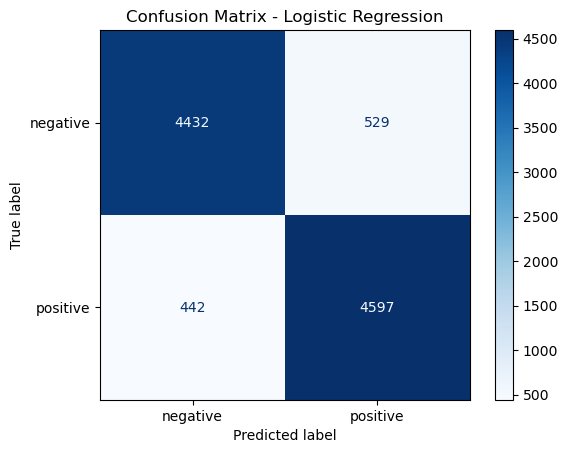

In [59]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(6,4))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


#### Final model Logistic Regression


In [29]:
## Fine tuning Logistic regresssion model
param_grid={
       'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

In [30]:
lr_model=LogisticRegression(max_iter=1000)

In [32]:
search = RandomizedSearchCV(lr_model, param_distributions=param_grid,
                            n_iter=10, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

In [33]:
search.fit(x_train_vec,y_train)

C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'solver': ['liblinear', 'saga']},
                   scoring='accuracy', verbose=1)

In [35]:
best_params=search.best_params_

In [36]:
final_model=LogisticRegression(**best_params)
final_model.fit(x_train_vec,y_train)

LogisticRegression(C=10, solver='saga')

In [42]:
y_pred=final_model.predict(x_test_vec)

In [43]:
# Evaluate
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.90      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 0.9029


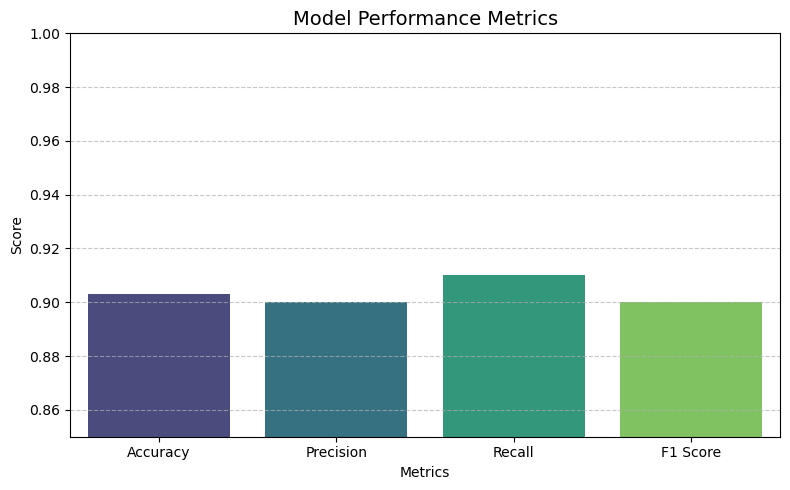

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {'Accuracy': 0.9029, 'Precision': 0.90, 'Recall': 0.91, 'F1 Score': 0.90}
names = list(metrics.keys())
scores = list(metrics.values())

plt.figure(figsize=(8, 5))
sns.barplot(x=names, y=scores, palette='viridis')
plt.ylim(0.85, 1)
plt.title("Model Performance Metrics", fontsize=14)
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Conclusion
In this sentiment analysis project, we aimed to classify IMDb movie reviews as positive or negative using natural language processing (NLP) techniques. We built a complete NLP pipeline that included data preprocessing, vectorization, and model training.

After experimenting with several algorithms—Naive Bayes, Random Forest, and Logistic Regression—we found that Logistic Regression yielded the best performance. After hyperparameter tuning, our final model achieved:

Accuracy: 90.29%
Precision: 90%
Recall: 91%
F1 Score: 90%
This reflects a strong generalization ability on unseen test data.

## Business Outcome
This sentiment analysis model enables effective tracking of customer satisfaction by quantifying the polarity of user reviews.